# Chatting users

Chatting users are defined as users which use many of the tweets to chat with other users. These chatting tweets can be identified by their contents, for example pronouns like *I* and *you* and specific verb forms like *am*.

In [8]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import numpy as np
import os
import pandas as pd
import re
from IPython.display import clear_output
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
DATADIR = "../data/text/"
QUERY_USERS = r'\b(ik|mij|me|jij|je|jou|jouw|jullie|heb|ben)\b'

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

## 1. Select users (skip)

In [17]:
YEAR= "2021"

In [18]:
files = sorted(os.listdir(DATADIR))
pattern = f"^{YEAR}"
totals = {}
matches = {}
for file_name in files:
    if re.search(pattern, file_name):
        squeal(file_name)
        df = pd.read_csv(DATADIR+file_name, index_col="id_str")
        user_counts = df["user"].value_counts()
        for user in user_counts.keys():
            if user in totals:
                totals[user] += user_counts[user]
            else:
                totals[user] = user_counts[user]
        matching_rows = df["text"].str.contains(QUERY_USERS, flags=re.IGNORECASE)
        matching_counts = df[matching_rows]["user"].value_counts()
        for user in matching_counts.keys():
            if user in matches:
                matches[user] += matching_counts[user]
            else:
                matches[user] = matching_counts[user]        

20211031-23.out.gz


In [19]:
chatting_users = {} 
for user in matches:
    if matches[user] >= 0.5 * totals[user] and matches[user] > 10:
        chatting_users[user] = True

In [20]:
len(chatting_users)

126645

In [22]:
pd.DataFrame(chatting_users.keys()).to_csv(f"csv/chatting_users_{YEAR}.csv", index=None)

## 2. Count tweets (skip)

In [30]:
TOPIC_HAPPY = "blij"
QUERY_TOPIC_HAPPY = r'(blij|blije)\b'
TOPIC_LONESOME = "eenzaam"
QUERY_TOPIC_LONESOME = r'\b(eenzaam|eenzam)'
TOPIC_STRESS = "stress"
QUERY_TOPIC_STRESS = r'moe\b|depress|depri|bang|angst|paniek|stress'
QUERY_I = r'\b(ik|mij|me)\b'

TOPIC = TOPIC_HAPPY
QUERY_TOPIC = QUERY_TOPIC_HAPPY

In [24]:
def process(df_merged, date, hours_matched, tweets, query_topic):
    matching_rows_topic = df_merged["text"].str.contains(query_topic, flags=re.IGNORECASE)
    matching_rows_i = df_merged["text"].str.contains(QUERY_I, flags=re.IGNORECASE)
    matches_df = df_merged[matching_rows_topic & matching_rows_i]
    matches = len(matches_df)
    misses = len(df_merged[(matching_rows_topic == False) | (matching_rows_i == False)])
    hours_matched[date] = (matches, misses)
    tweets.extend(matches_df.values.tolist())
    
date = "20200301-00"
hours_matched = {}
tweets = []
df_merged = pd.DataFrame([{"user":"test", "text": "ik"}, {"user":"test", "text": "blij"}])
process(df_merged, date, hours_matched, tweets, QUERY_TOPIC_LONESOME)
assert hours_matched[date] == (0, 2)
assert len(tweets) == 0
hours_matched = {}
tweets = []
df_merged = pd.DataFrame([{"user":"test", "text": "ik blij"}, {"user":"test", "text": ""}])
process(df_merged, date, hours_matched, tweets, QUERY_TOPIC_HAPPY)
assert hours_matched[date] == (1, 1)
assert len(tweets) == 1

In [25]:
YEAR = "2021"
pattern = f"^{YEAR}"
chatting_users = { user: True for user in list(pd.read_csv(f"csv/chatting_users_{YEAR}.csv", index_col=None).iloc[:,0])}

In [31]:
hours_matched = {}
tweets = []
files = sorted(os.listdir(DATADIR))
for file_name in files:
    if re.search(pattern, file_name):
        squeal(file_name)
        date = re.sub(".out.gz", "", file_name)
        df = pd.read_csv(DATADIR+file_name)
        df_merged = pd.merge(df, pd.DataFrame(chatting_users.keys(), columns=["user"]), on=["user"])
        process(df_merged, date, hours_matched, tweets, QUERY_TOPIC)

20211031-23.out.gz


In [34]:
pd.DataFrame(tweets, columns=["id_str", "in_reply_to_status_id_str", "user", "verified", "text", "location"]).to_csv(f"csv/hours_matched_{YEAR}_{TOPIC}_tweets.csv", index=None)

In [35]:
pd.DataFrame([ [hour] + list(hours_matched[hour]) for hour in hours_matched ], columns=["hour", "matched", "missed"]).to_csv(f"csv/hours_matched_{YEAR}_{TOPIC}.csv", index=None)

## 3. Make graph

In [36]:
def moving_median(number_list, size):
    new_list = []
    start_offset = int(size/2)
    for i in range(0, len(number_list)):
        start = max(0, i-start_offset)
        end = min(len(number_list), i+start_offset+1)
        new_list.append(np.median(number_list[start:end]))
    return new_list

In [37]:
def extract_date_data_counts(hours_matched):
    date_data_freqs = {}
    date_data_counts = {}
    for hour in hours_matched:
        date = re.sub("-[0-9][0-9]$", "", hour)
        if date not in date_data_freqs:
             date_data_freqs[date] = [0, 0]
        date_data_freqs[date][0] += int(hours_matched[hour][0])
        date_data_freqs[date][1] += int(hours_matched[hour][1])
        if date_data_freqs[date][0] + date_data_freqs[date][1] > 0:
            date_data_counts[date] = date_data_freqs[date][0] / ( date_data_freqs[date][0] + date_data_freqs[date][1] )
    return date_data_counts

In [38]:
def make_plot_data(date_data_counts):
    x = [datetime.datetime.strptime(date, f"%Y%m%d") for date in date_data_counts]
    y = moving_median(list(date_data_counts.values()), WINDOW_SIZE)
    return x, y


def make_date_data_counts(year, topic):
    hours_matched_list = pd.read_csv(f"csv/hours_matched_{year}_{topic}.csv", index_col=None).to_dict(orient="records")
    hours_matched = {}
    for row in hours_matched_list:
        hours_matched[row["hour"]] = [row["matched"], row["missed"]]
    date_data_counts = extract_date_data_counts(hours_matched)
    return date_data_counts

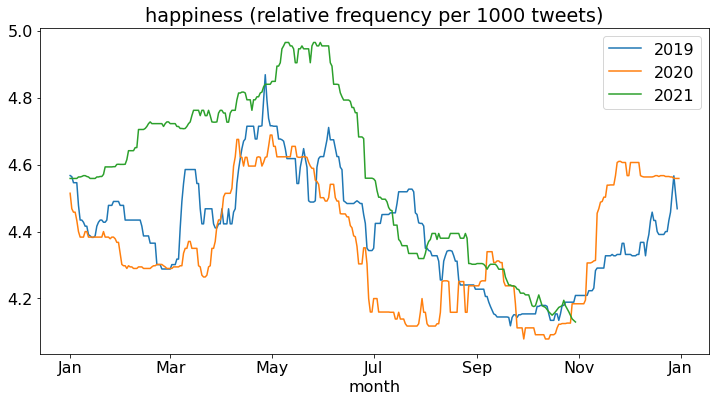

In [41]:
WINDOW_SIZE = 60

TOPIC = "blij"
TOPIC_EN = {"blij": "happiness", "eenzaam": "loneliness"}[TOPIC]

date_data_counts_2018 = make_date_data_counts("2018", TOPIC)
date_data_counts_2019 = make_date_data_counts("2019", TOPIC)
date_data_counts_2020 = make_date_data_counts("2020", TOPIC)
date_data_counts_2021 = make_date_data_counts("2021", TOPIC)
date_data_counts = dict(date_data_counts_2018)
date_data_counts.update(dict(date_data_counts_2019))
date_data_counts.update(dict(date_data_counts_2020))
date_data_counts.update(dict(date_data_counts_2021))

x, y = make_plot_data(date_data_counts)
x_2018 = x[:len(date_data_counts_2018)]
x_2019 = x[len(date_data_counts_2018):len(date_data_counts_2018)+len(date_data_counts_2019)]
x_2020 = x[len(date_data_counts_2018)+len(date_data_counts_2019):len(date_data_counts_2018)+len(date_data_counts_2019)+len(date_data_counts_2020)]
x_2021 = x[len(date_data_counts_2018)+len(date_data_counts_2019)+len(date_data_counts_2020):]
y_2018 = y[:len(date_data_counts_2018)]
y_2019 = y[len(date_data_counts_2018):len(date_data_counts_2018)+len(date_data_counts_2019)]
y_2020 = y[len(date_data_counts_2018)+len(date_data_counts_2019):len(date_data_counts_2018)+len(date_data_counts_2019)+len(date_data_counts_2020)]
y_2021 = y[len(date_data_counts_2018)+len(date_data_counts_2019)+len(date_data_counts_2020):]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(12, 6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
#ax.plot_date(x_2020[:len(y_2018)], y_2018, fmt="-", label="2018")
ax.plot_date(x_2020[:len(y_2019)], [ 1000*y for y in y_2019 ], fmt="-", label="2019")
ax.plot_date(x_2020, [ 1000*y for y in y_2020 ], fmt="-", label="2020")
ax.plot_date(x_2020[:len(y_2021)], [ 1000*y for y in y_2021 ], fmt="-", label="2021")
plt.title(f"{TOPIC_EN} (relative frequency per 1000 tweets)")
plt.xlabel("month")
plt.ylabel("")
plt.legend()
plt.savefig(f"{TOPIC}.png")
plt.show()

In [42]:
len(x_2019), len(x_2020), len(x_2021), len(y_2019), len(y_2020), len(y_2021), len(x), len(y), len(date_data_counts_2019), len(date_data_counts_2020), len(date_data_counts_2021),

(365, 366, 304, 365, 366, 304, 1400, 1400, 365, 366, 304)

## 4.Process annotations

In [15]:
DATA_FILE = "../data/annotation/eenzaam_2020.csv"
df_data = pd.read_csv(DATA_FILE, index_col=['id_str'])
df_annotation = pd.read_csv(DATA_FILE + ".human-labels.txt", header=None, sep=" ")

In [13]:
df_data

,in_reply_to_status_id_str,user,verified,text,location
id_str,,,,,
1212168318007812096,1.212167e+18,Yazid_NL,NaN,@Orihime_Inoue27 Dat is toch lief van mij.. \n...,The woods
1212306665040683009,NaN,MylifewithF,NaN,Onze Facebook groep heb ik gister opgestart en...,NaN
1212326477569634305,NaN,ekkendonk,NaN,#delen Ik vind het moeilijk om openlijk te ver...,"Noord-Brabant, Nederland"
1213658296000880640,NaN,WebCamBabesNL,NaN,Hello Lieverd van mij. Ik ben een lekkere jong...,WorldWide
1214256611608453120,1.213743e+18,J12011193,NaN,@EenzameH Volgende keer maar met mij😳😊,NaN
...,...,...,...,...,...
1343954639633473536,1.343954e+18,ThomasPruijsen,NaN,Ik sta nog steeds 100% achter mijn blog en ope...,Nijmegen
1343975651477512195,NaN,ellavangassen,NaN,"Jaaroverzicht kijken: blijten bij BLM-beelden,...","Antwerpen, België"
1343979622522900480,1.343949e+18,1903George,NaN,@TheAllSeeing4 @JoostNiemoller @Lies69616541 I...,NaN


In [16]:
df_annotation

,0,1,2,3,4
0,erikt@xs4all.nl,20210505204635,1212168318007812096,0,IRRELEVANT
1,erikt@xs4all.nl,20210505204635,1212326477569634305,2,RELEVANT
2,erikt@xs4all.nl,20210505204641,1212306665040683009,1,IRRELEVANT
3,erikt@xs4all.nl,20210505204715,1213658296000880640,3,IRRELEVANT
4,erikt@xs4all.nl,20210505204719,1214256611608453120,4,IRRELEVANT
...,...,...,...,...,...
615,erikt@xs4all.nl,20210506134319,1343954639633473536,607,IRRELEVANT
616,erikt@xs4all.nl,20210506134328,1343975651477512195,608,IRRELEVANT
617,erikt@xs4all.nl,20210506134403,1343979622522900480,609,IRRELEVANT
618,erikt@xs4all.nl,20210506134417,1344626935905873921,610,RELEVANT
